<a href="https://colab.research.google.com/github/hayashiyus/First-steps-towards-Deep-Learning/blob/main/31_CNN_and_RNN.ipynb" target="_parent">
 <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [53]:
#@title install packages
!pip install mplcyberpunk
!pip install watermark

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import mplcyberpunk

In [3]:
import re
import os
import copy
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <2DA9257B-4A11-392E-A85D-FE9CA74E0785> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
np.random.seed(0)
torch.manual_seed(0)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### **1.　畳み込みニューラルネット(CNN)**
畳み込みニューラルネットは [入力層→畳み込み層→プーリング層→全結合層→出力層] という構造をしている．

入力層→畳み込み層→プーリング層までの各層における出力は画像の大きさ×チャンネル数の形式をしており

畳み込み層
$$\begin{aligned}
u_{i j}^{(\ell)}=\sum_{p, q} h_{p q} z_{i+p, j+q}^{(\ell-1)}
\end{aligned}$$

プーリング層
$$\begin{aligned}
u_{i j k}^{(\ell)}=\max _{(p, q) \in \mathcal{P}_{i j}} z_{p q k}^{(\ell-1)}
\end{aligned}$$

によって，入力データから特徴量が抽出されていく．全結合層に入力する前に総入力（活性）の形式をベクトル形式に修正する必要がある．<br>
最後に出力層から，入力画像がどの教師ラベルに対応するのかを，教師ラベル別の確率として出力する．

ここで紹介するCNNモデルは，PyTorchの公式チュートリアルを参照している．<br>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

##### **問1：畳み込みニューラルネットの実装**
CIFAR10データセット（60,000枚，10クラス，32x32ピクセルのカラー画像）を分類する畳み込みニューラルネットを実装してください．

* ラベル 0： airplane（飛行機）
* ラベル 1： automobile（自動車）
* ラベル 2： bird（鳥）
* ラベル 3： cat（猫）
* ラベル 4： deer（鹿）
* ラベル 5： dog（犬）
* ラベル 6： frog（カエル）
* ラベル 7： horse（馬）
* ラベル 8： ship（船）
* ラベル 9： truck（トラック）

##### **例1**

In [51]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <2DA9257B-4A11-392E-A85D-FE9CA74E0785> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-package

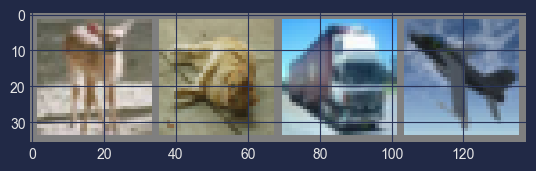

deer  cat   truck plane


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
plt.style.use("cyberpunk")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <2DA9257B-4A11-392E-A85D-FE9CA74E0785> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-package

Image batch dimensions: torch.Size([4, 3, 32, 32])
Image label dimensions: torch.Size([4])


In [11]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
## test the model with 1 batch
model = CNN()
for images, labels in trainloader:
    print("batch size:", images.shape)
    y_hat = model(images)
    print(y_hat.shape)
    break

/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <2DA9257B-4A11-392E-A85D-FE9CA74E0785> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-package

batch size: torch.Size([4, 3, 32, 32])
torch.Size([4, 10])


In [17]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [18]:
# エポック数
epochs = 50
# 学習率
learning_rate = 0.0001

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
for epoch in range(epochs):
    # モデルの訓練
    model.train()
    temp_train_loss = []
    temp_train_acc = []
    for i, (images, labels) in enumerate(trainloader):
        labels_pred = model(images)
        loss = criterion(labels_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temp_train_loss.append(loss.detach())
        temp_acc = get_accuracy(labels_pred, labels, batch_size)
        temp_train_acc.append(temp_acc) 
    train_loss.append(np.average(temp_train_loss))    # 訓練誤差をリストに保存
    train_accuracy.append(np.average(temp_train_acc)) # 予測性能をリストに保存
    # モデルの評価
    model.eval()
    temp_test_loss = []
    temp_test_acc = []
    for i, (images, labels) in enumerate(testloader):    
        labels_pred = model(images)
        loss = criterion(labels_pred, labels)
        temp_test_loss.append(loss.detach())
        temp_acc = get_accuracy(labels_pred, labels, batch_size)
        temp_test_acc.append(temp_acc) 
    test_loss.append(np.average(temp_test_loss))    # 訓練誤差をリストに保存
    test_accuracy.append(np.average(temp_test_acc)) # 訓練誤差をリストに保存

/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <2DA9257B-4A11-392E-A85D-FE9CA74E0785> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-package

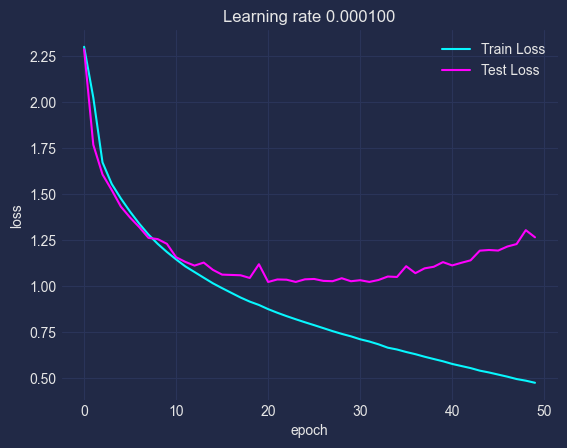

In [19]:
plt.style.use("cyberpunk")
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, c='magenta', label='Test Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.legend()
plt.show()

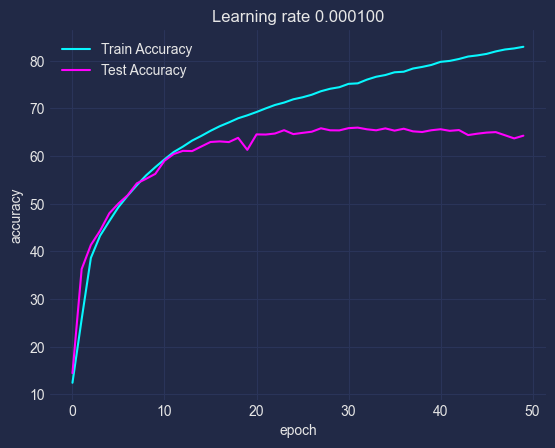

In [20]:
plt.style.use("cyberpunk")
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, c='magenta', label='Test Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.legend()
plt.show()

In [30]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

In [31]:
model = CNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <8080486D-E510-3000-AA6A-F3AD49ACC172> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/image.so
  Expected in:     <2DA9257B-4A11-392E-A85D-FE9CA74E0785> /Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/Yusuke.Hayashi/Library/Python/3.9/lib/python/site-package

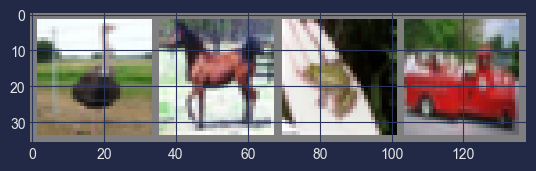

In [34]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
plt.style.use("cyberpunk")
imshow(torchvision.utils.make_grid(images))

In [35]:
labels_pred = model(images)
_, predicted = torch.max(labels_pred, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  bird  horse frog  truck


### **2.　再帰型ニューラルネット(RNN)**
再帰型ニューラルネットは [入力層→中間層→出力層] という構造をしているが，中間層から中間層へループを1つ，出力層から中間層へもう一つループを持っている．

中間層→出力層までの各層における活性，出力は次のようになっている．

$$\begin{aligned}
& \hat{\boldsymbol{y}}^t=f^{\text {out }}\left(\boldsymbol{v}^t\right) \\
& \ \ \ \ \uparrow \\
& \boldsymbol{v}^t=\boldsymbol{W}^{\text {out }} \boldsymbol{z}^t \\
& \ \ \ \ \uparrow \\
& \boldsymbol{z}^t=f\left(\boldsymbol{u}^t\right) \\
& \ \ \ \ \uparrow \\
& \boldsymbol{u}^t=\boldsymbol{W}^{i n} \boldsymbol{x}^t+\boldsymbol{W} \boldsymbol{z}^{t-1}+\widetilde{\boldsymbol{W}} \hat{\boldsymbol{y}}^{t-1} \\
& \ \ \ \ \uparrow
\end{aligned}$$

ここで紹介するRNNモデルは，PyTorchの公式チュートリアルを参照している．<br>
https://pytorch.org/tutorials/beginner/chatbot_tutorial.html　<br>
https://pytorch.org/tutorials/beginner/deploy_seq2seq_hybrid_frontend_tutorial.html

##### **問2：再帰型ニューラルネットの実装**
cornell movie-dialogs corpusデータセット（映画中の登場人物が交わした会話を２組のペアにしたデータ）を学習し，再帰型ニューラルネットを使ったChatbotを実装してください．

* 10,292組の映画の登場人物が交わした220,579の会話のやりとり
* 617本の映画から9,035人のキャラクターが登場
* 合計304,713語!

##### **例2**

In [36]:
device = torch.device("cpu")

# Maximum sentence length
MAX_LENGTH = 10

# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

In [37]:
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True
        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))
        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens
        for word in keep_words:
            self.addWord(word)


# Lowercase and remove non-letter characters
def normalizeString(s):
    s = s.lower()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


# Takes string sentence, returns sentence of word indexes
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

In [38]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # type: (Tensor, Tensor, Optional[Tensor]) -> Tuple[Tensor, Tensor]
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [39]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [40]:
# TorchScript Notes:
# ~~~~~~~~~~~~~~~~~~~~~~
#
# Similarly to the ``EncoderRNN``, this module does not contain any
# data-dependent control flow. Therefore, we can once again use
# **tracing** to convert this model to TorchScript after it
# is initialized and its parameters are loaded.
#

class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [41]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder, decoder_n_layers):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._device = device
        self._SOS_token = SOS_token
        self._decoder_n_layers = decoder_n_layers

    __constants__ = ['_device', '_SOS_token', '_decoder_n_layers']

    def forward(self, input_seq : torch.Tensor, input_length : torch.Tensor, max_length : int):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:self._decoder_n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=self._device, dtype=torch.long) * self._SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=self._device, dtype=torch.long)
        all_scores = torch.zeros([0], device=self._device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [42]:
def evaluate(searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words

# Evaluate inputs from user input (stdin)
def evaluateInput(searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

# Normalize input sentence and call evaluate()
def evaluateExample(sentence, searcher, voc):
    print("> " + sentence)
    # Normalize sentence
    input_sentence = normalizeString(sentence)
    # Evaluate sentence
    output_words = evaluate(searcher, voc, input_sentence)
    output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
    print('Bot:', ' '.join(output_words))

In [47]:
save_dir = os.path.join("data", "save")
corpus_name = "cornell movie-dialogs corpus"

# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# If you're loading your own model
# Set checkpoint to load from
checkpoint_iter = 4000
# loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                             '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                             '{}_checkpoint.tar'.format(checkpoint_iter))

# If you're loading the hosted model
#loadFilename = 'https://download.pytorch.org/models/tutorials/4000_checkpoint.tar'
loadFilename = '4000_checkpoint.tar'

# Load model
# Force CPU device options (to match tensors in this tutorial)
checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
encoder_sd = checkpoint['en']
decoder_sd = checkpoint['de']
encoder_optimizer_sd = checkpoint['en_opt']
decoder_optimizer_sd = checkpoint['de_opt']
embedding_sd = checkpoint['embedding']
voc = Voc(corpus_name)
voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
# Load trained model params
encoder.load_state_dict(encoder_sd)
decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [48]:
### Compile the whole greedy search model to TorchScript model
# Create artificial inputs
test_seq = torch.LongTensor(MAX_LENGTH, 1).random_(0, voc.num_words).to(device)
test_seq_length = torch.LongTensor([test_seq.size()[0]]).to(device)
# Trace the model
traced_encoder = torch.jit.trace(encoder, (test_seq, test_seq_length))

### Convert decoder model
# Create and generate artificial inputs
test_encoder_outputs, test_encoder_hidden = traced_encoder(test_seq, test_seq_length)
test_decoder_hidden = test_encoder_hidden[:decoder.n_layers]
test_decoder_input = torch.LongTensor(1, 1).random_(0, voc.num_words)
# Trace the model
traced_decoder = torch.jit.trace(decoder, (test_decoder_input, test_decoder_hidden, test_encoder_outputs))

### Initialize searcher module by wrapping ``torch.jit.script`` call
scripted_searcher = torch.jit.script(GreedySearchDecoder(traced_encoder, traced_decoder, decoder.n_layers))

In [49]:
# Set dropout layers to eval mode
scripted_searcher.eval()

# Evaluate examples
sentences = ["hello", "what's up?", "who are you?", "where am I?", "where are you from?"]
for s in sentences:
    evaluateExample(s, scripted_searcher, voc)

# Evaluate your input
#evaluateInput(traced_encoder, traced_decoder, scripted_searcher, voc)

> hello
Bot: hello .
> what's up?
Bot: i m going to get my car .
> who are you?
Bot: i m the owner .
> where am I?
Bot: in the house .
> where are you from?
Bot: south america .


In [50]:
evaluateExample('What is your name?', scripted_searcher, voc)

> What is your name?
Bot: jacob .


In [52]:
%load_ext watermark
%watermark --iversions

pandas      : 1.5.0
re          : 2.2.1
torchvision : 0.13.1
torch       : 1.13.0
numpy       : 1.22.4
matplotlib  : 3.6.0
mplcyberpunk: 0.6.0

